!pip install numpy==1.23.4

In [ ]:
FEATURE_SELECTION = False

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')
import time

In [30]:
from utils import modeling_utils as mu

In [31]:
from scipy.stats import pearsonr
from sklearn.svm import SVC

In [32]:
df = pd.read_csv('../data/german_credit_data.csv')
df = df.drop(['Unnamed: 0'], axis=1)
df.columns = [x.lower().replace(' ', '_') for x in df.columns]

In [33]:
df = df.sample(frac=0.1, random_state=42).reset_index(drop=True)

In [34]:
job_dic = {
    0: 'unskilled non res',
    1: 'unskilled resident',
    2: 'skilled',
    3: 'highly skilled'
}
df.job = df.job.map(job_dic)

In [35]:
numerical_features = ['age', 'credit_amount', 'duration']
categorical_features = ['sex', 'job', 'housing', 'saving_accounts', 'checking_account', 'purpose']

In [36]:
df.saving_accounts = df.saving_accounts.fillna('undefined')
df.checking_account = df.checking_account.fillna('undefined')

In [37]:
df.isna().sum().sum()

0

In [38]:
df['target'] = (df.risk == 'bad').astype(int)
df.sample(3)

,age,sex,job,housing,saving_accounts,checking_account,credit_amount,duration,purpose,risk,target
35,36,male,skilled,free,undefined,moderate,2760,24,car,good,0
75,48,male,skilled,own,little,little,1024,24,radio/TV,bad,1
54,44,male,skilled,own,moderate,moderate,1804,12,car,good,0


In [39]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop(['risk', 'target'], axis=1), df.target, 
                                                    test_size=0.2, random_state=42, stratify = df.target)

In [40]:
from sklearn.base import BaseEstimator, TransformerMixin

class PreprocessingTransformer(BaseEstimator, TransformerMixin):
    def __init__(self,  numerical_features, categorical_features, dropped_features = []):
        self.dropped_features = dropped_features
        self.numerical_features = numerical_features
        self.categorical_features = categorical_features
        pass
    
    def fit(self, X, y=None):
        self.categorical_features_order = mu.sort_categorical_values_by_correlation(X.copy(), y, self.categorical_features)
        self.positive_and_negative_indicators_frme = mu.find_positive_and_negative_indicators(X.copy(), y, self.numerical_features, self.categorical_features)
        return self

    def transform(self, X):
        X = mu.encode_categorical_values(X.copy(), self.categorical_features_order)
        X = mu.apply_indicators_conditions(X.copy(), self.positive_and_negative_indicators_frme)
        X = X.drop(self.dropped_features, axis = 1)
        self.features = X.columns
        return X


In [41]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [42]:
## bayes optimization

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer


In [43]:
def test_pipeline(model, model_params, cv, n_iter, print_scores=True, dropped_features = []):

    pipeline = Pipeline([
        ('preprocess', PreprocessingTransformer(numerical_features, categorical_features,
                                                dropped_features=dropped_features)), 
        ('model', model)
        ])

    bayes_search = BayesSearchCV(
        pipeline,
        model_params,
        cv=cv,
        verbose=-1,
        n_jobs=-1,
        return_train_score=True,
        n_iter = n_iter,
        scoring='roc_auc'
    )

    bayes_search.fit(X_train, y_train)

    best_estimator_test_score = bayes_search.best_score_
    best_estimator_train_score = bayes_search.cv_results_['mean_train_score'][bayes_search.best_index_]

    output = {
        'best_estimator_test_score': best_estimator_test_score,
        'best_estimator_train_score': best_estimator_train_score,
        'best_estimator_test_score_std': bayes_search.cv_results_['std_test_score'][bayes_search.best_index_],
        'best_estimator': bayes_search.best_estimator_,
        'best_params': bayes_search.best_params_
    }
    mu.warn(model_params, bayes_search.best_params_)

    if print_scores == True:
        print('best estimator test score:', best_estimator_test_score)
        print('best estimator train score:', best_estimator_train_score)

    return output, bayes_search


## model selection

In [44]:
cv, n_iter = 5, 30

## lgbm (gradient boosting)

In [45]:
model = lgb.LGBMClassifier(verbose = -1, n_estimators=30)

model_params = {
    'model__num_leaves': Integer(10, 100, 'uniform'),
    'model__feature_fraction': Real(0.1, 1, 'uniform'),
    'model__learning_rate': Real(0.001, 0.1, 'log-uniform'),
    'model__min_child_samples': Integer(5, 200, 'uniform'),
    'model__boosting_type': Categorical(['gbdt', 'dart', 'goss']),
    'model__n_estimators': Integer(30, 300, 'uniform'),
}

boosting_test_results, _ = test_pipeline(model, model_params, cv, n_iter)

best estimator test score: 0.8237500000000001
best estimator train score: 0.8853750317823545


## lgbm (random forest)

In [46]:
model = lgb.LGBMClassifier(verbose = -1, boosting_type ='rf', 
                            bagging_freq = 1, bagging_fraction =0.6, n_estimators=100)

model_params = {
    'model__num_leaves': Integer(10, 100, 'uniform'),
    'model__feature_fraction': Real(0.1, 1, 'uniform'),
    'model__min_child_samples': Integer(5, 200, 'uniform'),
}

bagging_test_results, _ = test_pipeline(model, model_params, cv, n_iter)

best estimator test score: 0.7884090909090908
best estimator train score: 0.8949046529366896


## feature selection

In [47]:
all_features = numerical_features + categorical_features + ['positive_negative_balance', 'number_positive_indicators', 'number_negative_indicators']

In [ ]:
def selection_round(n_evaluations, model, model_params, all_features, previously_removed):
    rows = []

    all_tested_feats = [x for x in all_features if x not in previously_removed]

    for i in range(n_evaluations):
        for tested_feature in (all_tested_feats + [[]])[::-1]:
            feature_formatted = tested_feature if type(tested_feature) == list else [tested_feature]
            dropped = list(set(feature_formatted).union(set(previously_removed)))
            res, _ = test_pipeline(model, model_params, 5, 5, dropped_features=dropped, print_scores=False)
            res = (pd.DataFrame({
                    'removed_feature': str(tested_feature),
                    'test_score': res['best_estimator_test_score']}, index=[0])
                    )
            rows.append(res)

    results = pd.concat(rows).reset_index(drop=True)

    results.removed_feature = results.removed_feature.astype(str)
    results ['avg_test_score'] = results.groupby('removed_feature').test_score.transform('mean')
    results = results.sort_values('avg_test_score', ascending=False).drop_duplicates('removed_feature').reset_index(drop=True)
    results = results.drop('test_score', axis=1)

    worse = results.iloc[0]
    worse_feature = worse.removed_feature


    if worse_feature == '[]':
        print('acabou')
        return '[]', results

    print('Removing', worse_feature)
    return worse_feature, results

In [ ]:
n_evaluations_per_round = 4

model_params = {
    'model__feature_fraction': Real(0.8, 1, 'uniform')
    }
model = lgb.LGBMClassifier(verbose = -1, boosting_type ='gbdt', n_estimators=100)


previously_removed = []
removed = ''

if FEATURE_SELECTION == False:
    removed = '[]' ## it's going to skip the while below

result = pd.DataFrame()
while removed != '[]':
    start = time.time()
    removed, round_res = selection_round(n_evaluations_per_round, model, model_params,
                        all_features[::-1], previously_removed = previously_removed)
    previously_removed.append(removed)
    round_res['round'] = len(previously_removed)
    round_res['round_removed'] = removed
    result = pd.concat([result, round_res])
    #display(round_res)
    print('Round time, ', round(time.time() - start, 1), 'seconds. Removed feature:', removed, '\n')

removing purpose
round time,  58.3 seconds. Removed feature: purpose 

removing credit_amount
round time,  53.0 seconds. Removed feature: credit_amount 

removing age
round time,  49.1 seconds. Removed feature: age 

acabou
round time,  44.3 seconds. Removed feature: [] 



In [ ]:
selected_out = previously_removed
selected_out.remove('[]')
selected_out

['purpose', 'credit_amount', 'age']

## final tuning and result

In [ ]:
best_params = boosting_test_results['best_params']
best_params

OrderedDict([('model__boosting_type', 'goss'),
             ('model__feature_fraction', 1.0),
             ('model__learning_rate', 0.1),
             ('model__min_child_samples', 5),
             ('model__n_estimators', 300),
             ('model__num_leaves', 100)])

In [ ]:
model = lgb.LGBMClassifier(verbose = -1, 
                            boosting_type = best_params['model__boosting_type'],
                            feature_fraction = best_params['model__feature_fraction'],
                            min_child_samples = best_params['model__min_child_samples'],
                            learning_rate = None, num_leaves = None, n_estimators = None)

model_params = {
    'model__learning_rate': Real(0.001, 0.1, 'log-uniform'),
    'model__num_leaves': Integer(10, 100, 'uniform'),
    'model__n_estimators': Integer(30, 300, 'uniform') 
    }

final_model_test_results, best_model = test_pipeline(model, model_params, cv = 5, n_iter = 5, dropped_features=selected_out)

best estimator test score: 0.7625
best estimator train score: 0.925


In [ ]:
final_model_test_results['best_params']

OrderedDict([('model__learning_rate', 0.08662322576439983),
             ('model__n_estimators', 55),
             ('model__num_leaves', 75)])

auc score: 0.8333333333333334


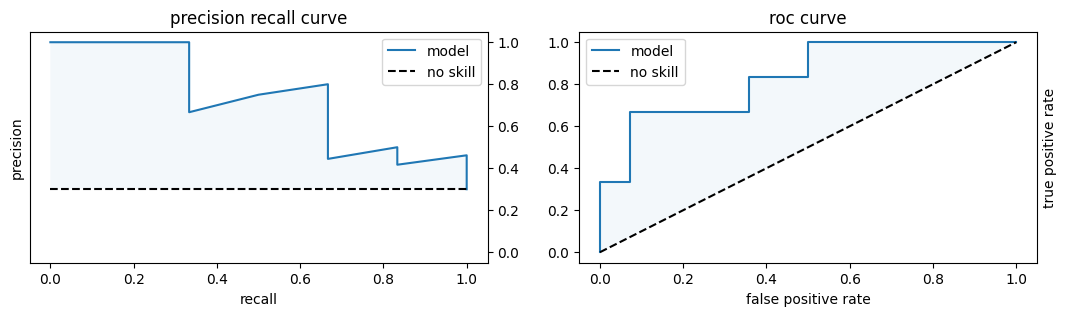

In [ ]:
## test be
# st_model on the test set

from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

y_pred_proba = best_model.predict_proba(X_test)[:,1]
print('auc score:', roc_auc_score(y_test, y_pred_proba))

## precision recall curve

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

class_imbalance = y_test.value_counts(normalize=True)[1]

_, ax = plt.subplots(1, 2, figsize=(13, 3))
ax[0].plot(recall, precision, label = 'model')
ax[0].plot([0, 1], [class_imbalance, class_imbalance], 'k--', label = 'no skill')
ax[0].fill_between(recall, precision, 0, alpha=0.05)
ax[0].fill_between([0, 1], [class_imbalance, class_imbalance], color = 'white')
ax[0].set_xlabel('recall')
ax[0].set_ylabel('precision')
ax[0].set_title('precision recall curve')
ax[0].yaxis.tick_right()
ax[0].set_ylim([-0.05, 1.05])
ax[0].legend()

ax[1].plot(fpr, tpr, label = 'model')
ax[1].plot([0, 1], [0, 1], 'k--', label = 'no skill')
ax[1].fill_between(fpr, tpr, 0, alpha=0.05)
ax[1].fill_between([0, 1], [0, 1], color = 'white')
ax[1].legend()


ax[1].set_xlabel('false positive rate')
ax[1].set_ylabel('true positive rate')
ax[1].set_title('roc curve')
ax[1].yaxis.set_label_position("right")

## print auc score

## threshold selection